# Gaussian Mixture Models
## Applications to synthetic scenario generation

#### Machine Learning for Quantitative Finance, Joerg Kienitz, joerg.kienitz@mrig.de

V1.2 - August 2025

This notebook serves as an illustration of the method of gmm application to simulating implied volatility surfaces.

This and any accompanying material are being provided solely for information and general illustrative
purposes. The author will not be responsible for the consequences of reliance upon any information contained in or
derived from the presentation or for any omission of information therefrom and hereby excludes all liability for loss
or damage (including, without limitation, direct, indirect, foreseeable, or consequential loss or damage and
including loss or profit and even if advised of the possibility of such damages or if such damages were foreseeable)
that may be incurred or suffered by any person in connection with the presentation, including (without limitation)
for the consequences of reliance upon any results derived therefrom or any error or omission whether negligent or
not. No representation or warranty is made or given by the author that the presentation or any content thereof will
be error free, updated, complete or that inaccuracies, errors or defects will be corrected.

The views are solely that of the authors and not of any affiliate institution. The Chatham House rules apply.
The presentation may not be reproduced in whole or part or delivered to any other person without prior permission
of the author.


The notebook must not be distributed.

We refer to: J, Gatheral, A. Jacquier, Arbitrage-free SVI volatility surfaces. 
Quantitative Finance, 14(1): 59-71, 2014. https://www.tandfonline.com/doi/full/10.1080/14697688.2013.819986

for the SSVI model and local variance

The notebook is designed to synthetically generate implied volatility surfaces using the SSVI model. This data is used for learning a GMM that is used to synthetically generate data from the learned distribution of the objects.

Loading already generated data (from a model, from market data, etc. ) is also possible.

In [1]:
# necessary packages

from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from matplotlib.colors import cnames
import pandas as pd
from scipy.optimize import bisect

import datetime

import pickle
from sklearn import mixture
from torch.utils.data.dataset import Dataset

from scipy.interpolate import RectBivariateSpline

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel

We consider the following SSVI parameterisation of the total implied variance surface:
$$
w(k,\theta_t)
= \frac{\theta_t}{2}\left\{1+\rho\varphi(\theta_t) k + \sqrt{\left(\varphi(\theta_t){k}+\rho\right)^2
+1-\rho^2 }\right\},
$$
with $\theta_t$ denotes the total at-the-money variance. Here $k:=\log(K/S_0)\in\mathbb{R}$ denotes the logmoneyness.

We then compute the (Dupire) local variance via the following formula:
$$
\sigma_{\mathrm{loc}}^2(k, T) := \frac{\partial_{t}w(k, \theta_{t})}{g(k, w(k, \theta_{t}))},
$$
for all $k\in\mathbb{R}$ and $t\geq 0$, where the function $g$ is fined in the paper.

Data could suggest some specific form for the increasing map $t\mapsto \theta_t$. For simplicity here, we take
$\theta_t \equiv \sigma^2 t$, for some $\sigma>0$.

The function~$\varphi$ is referred to as the backbone and needs to satisfy some assumptions to prevent arbitrage. We focus on two such specific examples below.

# Examples for $\varphi$ functions

1) We consider the following function
$$
\varphi(\theta)\equiv\frac{1}{\gamma\theta}\left\{1-\frac{1-\mathrm{e}^{-\gamma\theta}}{\gamma\theta}\right\},
$$
where $\gamma>0$, $\rho \in (-1,1)$.
We further need to impose $\gamma \geq \frac{1}{4}\left(1+|\rho|\right)$ in order to prevent arbitrage.

2) We consider the following function
$$
\varphi(\theta)\equiv\frac{\eta}{\theta^\gamma},
$$
where $\gamma \in (0,1/2]$.

In [2]:
phi_lambda = lambda theta, gamma, sigma, rho: 1./(gamma*theta)*(1.-(1.-np.exp(-gamma*theta))/(gamma*theta))
#phi_lambda = lambda theta, gamma, sigma, rho: 1./(gamma*theta)*(1.-(1.-np.exp(-gamma*theta))/(gamma*theta))

def SSVI_l(x, t, phi, params):
    gamma, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, gamma, sigma, rho)
    return 0.5*theta*(1.+rho*p*x+np.sqrt((p*x+rho)*(p*x+rho)+1.-rho*rho))

def SSVI1_l(x, t, phi, params):
    ## First derivative with respect to x
    gamma, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, gamma, sigma, rho)
    return 0.5*theta*p*(p*x+rho*np.sqrt(p*p*x*x+2.*p*rho*x+1.)+rho)/np.sqrt(p*p*x*x+2.*p*rho*x+1.)

def SSVI2_l(x, t, phi, params):
    ## Second derivative with respect to x
    gamma, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, gamma, sigma, rho)
    return 0.5*theta*p*p*(1.-rho*rho)/ ((p*p*x*x + 2.*p*rho*x + 1.)*np.sqrt(p*p*x*x+2.*p*rho*x+1.))
    
def SSVIt_l(x, t, phi, params):
    ## First derivative with respect to t, by central difference
    gamma, sigma, rho = params
    eps = 0.0001
    return (SSVI(x,t+eps,phi, params) - SSVI(x,t-eps,phi, params))/(2.*eps)

def g_l(x, t, phi, params):
    w = SSVI(x,t,phi,params)
    w1 = SSVI1(x,t,phi,params)
    w2 = SSVI2(x,t,phi,params)
    return (1.-0.5*x*w1/w)*(1.-0.5*x*w1/w) - 0.25*w1*w1*(0.25 + 1./w) + 0.5*w2
    
def dminus_l(x, t, phi,params):
    vsqrt = np.sqrt(SSVI(x,t,phi,params))
    return -x/vsqrt - 0.5*vsqrt
    
def densitySSVI_l(x, t, phi,params):
    dm = dminus(x,t,phi,params)
    return g(x,t,phi,params)*np.exp(-0.5*dm*dm)/np.sqrt(2.*np.pi*SSVI(x,t,phi,params))

def SSVI_LocalVarg_l(x, t, phi,params):
    ## Compute the equivalent SSVI local variance
    return SSVIt_l(x,t,phi,params) / g(x,t,phi,params)

# GMM SVI

In [3]:
def phi(theta, params):
    gamma, eta, sigma, rho = params
    return eta / pow(theta, gamma)

def SSVI(x, t, params):
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*(1.+rho*p*x+np.sqrt((p*x+rho)*(p*x+rho)+1.-rho*rho))

def SSVI1(x, t, params):
    ## First derivative with respect to x
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*p*(p*x+rho*np.sqrt(p*p*x*x+2.*p*rho*x+1.)+rho)/np.sqrt(p*p*x*x+2.*p*rho*x+1.)

def SSVI2(x, t, params):
    ## Second derivative with respect to x
    gamma, eta, sigma, rho = params
    theta = sigma*sigma*t
    p = phi(theta, params)
    return 0.5*theta*p*p*(1.-rho*rho)/ ((p*p*x*x + 2.*p*rho*x + 1.)*np.sqrt(p*p*x*x+2.*p*rho*x+1.))
    
def SSVIt(x, t, params):
    ## First derivative with respect to t, by central difference
    eps = 0.0001
    return (SSVI(x,t+eps,params) - SSVI(x,t-eps,params))/(2.*eps)

def g(x, t, params):
    w = SSVI(x,t,params)
    w1 = SSVI1(x,t,params)
    w2 = SSVI2(x,t,params)
    return (1.-0.5*x*w1/w)*(1.-0.5*x*w1/w) - 0.25*w1*w1*(0.25 + 1./w) + 0.5*w2
    

def dminus(x, t, params):
    vsqrt = np.sqrt(SSVI(x,t,params))
    return -x/vsqrt - 0.5*vsqrt
    
def densitySSVI(x, t, params):
    dm = dminus(x,t,params)
    return g(x,t,params)*np.exp(-0.5*dm*dm)/np.sqrt(2.*np.pi*SSVI(x,t,params))

def SSVI_LocalVarg(x, t, params):
    ## Compute the equivalent SSVI local variance
    return SSVIt(x,t,params) / g(x,t,params)

In [4]:
# define the Dataset for GMM


class GMMDataSet2d(Dataset):
    def __init__(self, file_name_gridk, file_name_gridt, file_name_vol):
        with open(file_name_vol, 'rb') as f:
            vol = pickle.load(f)
        with open(file_name_gridk, 'rb') as f:
            gridk = pickle.load(f)
        with open(file_name_gridt, 'rb') as f:
            gridt = pickle.load(f)
        self.xx = gridk
        self.t = gridt
        self.vols = vol
        
    def __len__(self):
        return np.shape(self.vols)[0]

    def __size__(self):
        return len(self.xx), len(self.t)
        
    def __getitem__(self, idx):
        return self.vols[idx]


# simulation of gaussians
def sim_nD_gaussian_mixture_model(means,variances,pis,nsamples = 1000, transform = False):
    # determine the dimensionality of the Gaussians
    dim = np.shape(np.atleast_2d(variances).T)[1]
    
    # accumulate the weights
    acc_pis = np.cumsum(pis)
    
    samples = []
    uniforms = np.random.uniform(0,1,nsamples)
    for i in range(nsamples):
        # sample uniform
        u = uniforms[i]
        
        # select gaussian
        if u <= acc_pis[0]:
            k  = 0
        else:
            k = np.max(np.where(acc_pis < u)[0])+1
    
        selected_mu = means[k]
        selected_cov = variances[k]

        if dim == 1:
            x_multi = np.random.normal(selected_mu, selected_cov)
        else:
            x_multi = np.random.multivariate_normal(selected_mu, selected_cov)

        if transform == False:
            while (x_multi<0).sum()>0:
                if dim == 1:
                    x_multi = np.random.normal(selected_mu, selected_cov)
                else:
                    x_multi = np.random.multivariate_normal(selected_mu, selected_cov)    
            
        samples.append(x_multi)

    return samples


'\nTO DO: simulation with all types of covariances\n        if gmm.covariance_type == "full":\n            covariances = gmm.covariances_[n][:2, :2]\n        elif gmm.covariance_type == "tied":\n            covariances = gmm.covariances_[:2, :2]\n        elif gmm.covariance_type == "diag":\n            covariances = np.diag(gmm.covariances_[n][:2])\n        elif gmm.covariance_type == "spherical":\n            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]\n'

## Numerical example

In [5]:
N_grid_x = 25
N_grid_t = 10

In [6]:
sigma, gamma, eta, rho = 0.2, 0.4, 0.2, -0.4
xx, TT = np.linspace(np.log(10/100), np.log(800./100), N_grid_x), np.linspace(0.5, 10., N_grid_t)

print("Consistency check to avoid static arbitrage: ", (gamma - 0.25*(1.+np.abs(rho))>0.))
params = gamma, eta, sigma, rho

localVarianceSSVI = [[SSVI_LocalVarg(x, t, params) for x in xx] for t in TT]

Consistency check to avoid static arbitrage:  True


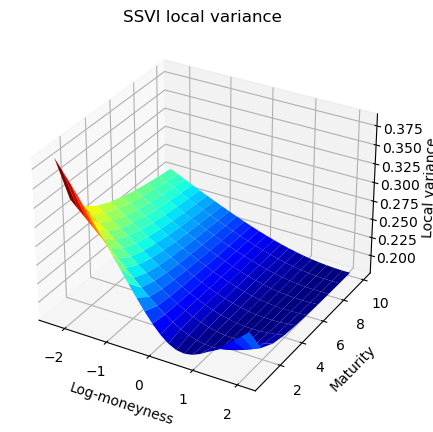

In [7]:
ax = plt.figure(figsize=(8,5)).add_subplot(projection='3d')
xxx, TTT = np.meshgrid(xx, TT)
localVarianceSSVI = np.array(localVarianceSSVI)
ax.plot_surface(xxx, TTT, np.sqrt(localVarianceSSVI), cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
ax.set_xlabel("Log-moneyness")
ax.set_ylabel("Maturity")
ax.set_zlabel("Local variance")
ax.set_title("SSVI local variance")
plt.show()

In [8]:
# random parameter generation
# standard: sigma, gamma, eta, rho = 0.2, 0.4, 0.2, -0.4
def r_gamma():
    l = 0.2
    u = 0.6
    d = u - l
    return l + d * np.random.rand()

def r_sigma():
    l = 0.05
    u = .45
    d = u - l
    return l + d * np.random.rand()

def r_eta():
    l = 0.1
    u = 0.4
    d = u - l
    return l + d * np.random.rand()
    
def r_rho():
    l = -.9
    u = -.2
    d = u - l
    return l + d * np.random.rand()

def r_params():
    # only generate no-arb surfaces
    sigma, gamma, eta, rho = r_sigma(), r_gamma(), r_eta(), r_rho()
    
    while gamma - 0.25*(1.+np.abs(rho))<=0.:
        sigma, gamma, eta, rho = r_sigma(), r_gamma(), r_eta(), r_rho()
    
    return sigma, gamma, eta, rho


In [9]:
# gennerate no-arb SSVI surfaces
generatedata = False

N_data = 100

if generatedata:
    lv_list = []
    iv_list = []

    for j in range(0,N_data):
        params = r_params()
    
        localVarianceSSVI = [[SSVI_LocalVarg(x, t, params) for x in xx] for t in TT]
        impliedVolatilitySSVI = [[np.sqrt(SSVI(x, t, params)/t) for x in xx] for t in TT]
    
        lv_list.append(localVarianceSSVI)
        iv_list.append(impliedVolatilitySSVI)

    lv_list = np.asarray(lv_list)
    iv_list = np.asarray(iv_list)

    # vol surface shape
    np.shape(lv_list)

In [10]:
# vol grid points
vol_gridk = np.asarray(xx)
vol_gridt = np.asarray(TT)

In [11]:
# store the vol grid and the surfaces
# create unique name
savefile = False

sim_date = datetime.datetime.now()
t_str = str(sim_date.strftime('%d_%m_%Y'))

vol_grid_k_str = 'vol_grid_k_'+ str(N_grid_x) + '_' + t_str + '.data'
vol_grid_t_str = 'vol_grid_t_'+ str(N_grid_t) + '_' + t_str + '.data'
vol_str = 'vol_k_'+ str(N_grid_x) + '_t_'+ str(N_grid_t) + '_' + t_str + '.data'
ivol_str = 'ivol_k_'+ str(N_grid_x) + '_t_'+ str(N_grid_t) + '_' + t_str + '.data'

print(vol_str)

if savefile == True:
    with open(vol_grid_k_str, 'wb') as f:
            pickle.dump(vol_gridk, f)

    with open(vol_grid_t_str, 'wb') as f:
            pickle.dump(vol_gridt, f)
    
    with open(vol_str, 'wb') as f:
            pickle.dump(lv_list, f)

    with open(ivol_str, 'wb') as f:
            pickle.dump(iv_list, f)
#with open('vol_grid_m_t.data', 'rb') as f:
#    new_data = pickle.load(f)
#np.shape(new_data)

vol_k_25_t_10_14_01_2025.data


In [12]:
# set up the dataset
kdata_str = 'vol_grid_k_25_09_08_2024.data'
tdata_str = 'vol_grid_t_10_09_08_2024.data'
vdata_str = 'vol_k_25_t_10_09_08_2024.data'
ivdata_str = 'ivol_k_25_t_10_09_08_2024.data'

#kdata_str = 'vol_grid_k_25_28_10_2024.data'
#tdata_str = 'vol_grid_t_10_28_10_2024.data'
#vdata_str = 'vol_k_25_t_10_28_10_2024.data'
#ivdata_str = 'ivol_k_25_t_10_28_10_2024.data'

volsurface = GMMDataSet2d(kdata_str, tdata_str, ivdata_str)

if generatedata:
    print('Nothing to do')
else:
    with open(vdata_str, 'rb') as f:
        lv_list = pickle.load(f)


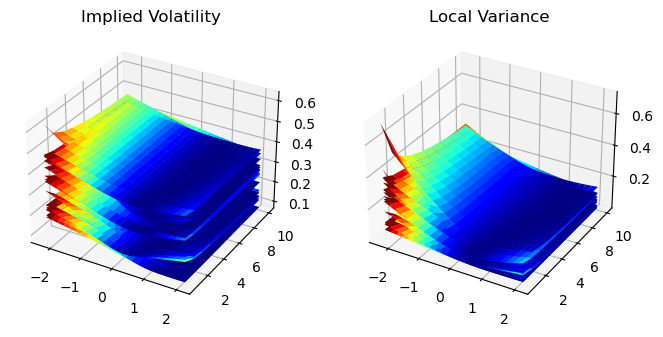

In [13]:
#plt_arr = [0,1,2,10,50,500,750,999,1000,2194,4345, 5645, 6300, 7834, 8435, 9945]
plt_arr = [0,1,2,10,40, 50,55,70,75,77, 80,83, 87, 88, 90, 91, 94, 97, 99]

fig = plt.figure(figsize=(8,5))
ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1,2,2, projection='3d')
xxx, TTT = np.meshgrid(volsurface.xx, volsurface.t)

for j in plt_arr:
    ax1.plot_surface(xxx, TTT, volsurface.vols[j], cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
    ax1.set_title('Implied Volatility')
    ax2.plot_surface(xxx, TTT, lv_list[j], cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
    ax2.set_title('Local Variance')

#fig.savefig('G:\PC_JK\Paper\Papers_My\GaussianMeanMixture_DCKE\SyntheticData\iv_scenarios.pdf')

In [14]:
volsurfaces = volsurface.vols
nsim, ndim1, ndim2 = np.shape(volsurfaces)

vsurf = volsurfaces.reshape((nsim,ndim1*ndim2))

In [15]:
# fit a GMM to the training data
usetransform = True

if usetransform:
    gmm_vol = mixture.GaussianMixture(n_components=5, covariance_type = 'full').fit(np.log(vsurf))       # create the mixture model
else:
    gmm_vol = mixture.GaussianMixture(n_components=5, covariance_type = 'full').fit(vsurf)       # create the mixture model

In [16]:
# simulate with the fitted GMM
Nsim = 100
vol_sim = sim_nD_gaussian_mixture_model(gmm_vol.means_,gmm_vol.covariances_,gmm_vol.weights_,nsamples = Nsim, transform = True)

if usetransform:
    vol_sim = np.exp(vol_sim)

#sim_vol_str = 'sim_vol_k_'+ str(N_grid_x) + '_t_'+ str(N_grid_t) + '_' + t_str + '.data'

#with open(sim_vol_str, 'wb') as f:
#        pickle.dump(vol_sim, f)

In [17]:
# reshape the data to make it into a surface again
vsurf_re = vsurf.reshape(nsim,ndim1,ndim2)
np.shape(vsurf_re)

(100000, 10, 25)

In [18]:
vol_sim_re = np.asarray(vol_sim).reshape(Nsim,ndim1,ndim2)

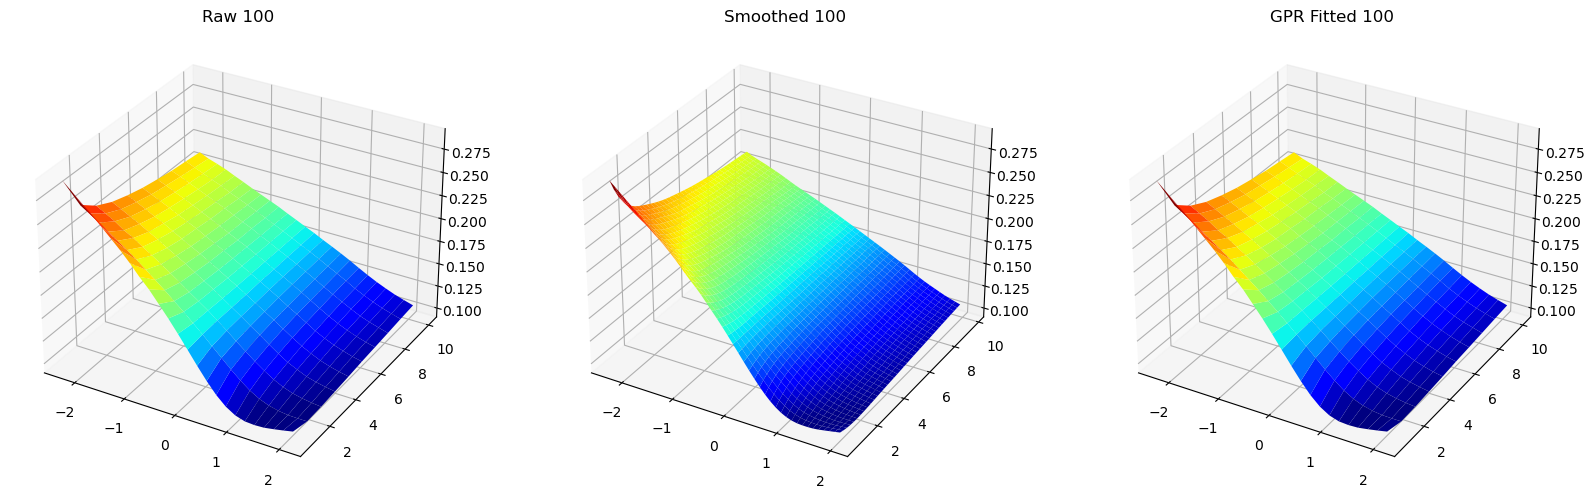

In [19]:
# plot the simulated surfaces
%matplotlib inline
from IPython.display import display, clear_output

fig = plt.figure(figsize=(20,10))

ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax3 = fig.add_subplot(1,3,3, projection='3d')
xxx, TTT = np.meshgrid(volsurface.xx, volsurface.t)

# adding grid points
xnew = np.arange(-2.3, 2.07, 1e-1)
ynew = np.arange(.5, 10., .25)
x_spline, t_spline = np.meshgrid(xnew, ynew)

# use standard grid
#xnew = volsurface.xx
#ynew = volsurface.t
#x_spline, t_spline = xxx, TTT

X = np.column_stack((xxx, TTT))

j = 0
for v in vol_sim_re:
    ax1.cla()
    ax2.cla()
    ax3.cla()
    
    func = RectBivariateSpline(volsurface.xx, volsurface.t, v.T, s=0)   # smoothing -> to be replaced with no-arb smoothing for ivol
    znew = func(xnew, ynew)
    
    ax1.plot_surface(xxx, TTT, v, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
    ax2.plot_surface(x_spline, t_spline, znew.T, cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
    ax1.set_title('Raw '+str(j+1))
    ax2.set_title('Smoothed '+ str(j+1))

    kernel = ConstantKernel(.5, constant_value_bounds="fixed") * RBF(2.0, length_scale_bounds="fixed")
#    kernel = ConstantKernel(.5) * RBF(5.0)
    gpr = GaussianProcessRegressor(kernel, normalize_y=False )
    gpr.fit(X,v)
    ax3.plot_surface(xxx, TTT, gpr.predict(X, return_std=False), cmap=plt.cm.jet, rstride=1, cstride=1, linewidth=0)
    ax3.set_title('GPR Fitted '+str(j+1))

    
    display(fig)
    #namestr = 'G:\PC_JK\Paper\Papers_My\GaussianMeanMixture_DCKE\SyntheticData\ivscnearios'+str(j)+'.pdf'
    #fig.savefig(namestr)

    clear_output(wait=True)
    plt.pause(.025)
    
    ax1.cla()
    ax2.cla()
    ax3.cla()

    j = j + 1
   

### Consider the Gaussian building blocks

Text(0.5, 0.92, 'GMM Means')

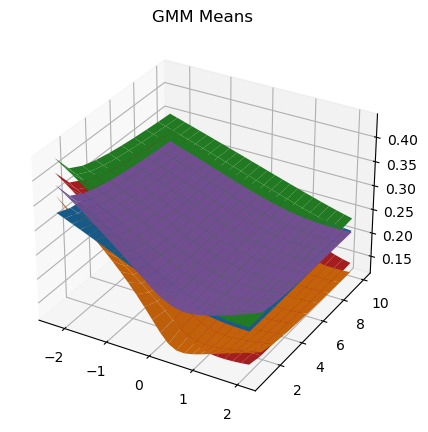

In [20]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1, projection='3d')

for g, w, i in zip(gmm_vol.means_, gmm_vol.weights_, range(0,len(gmm_vol.weights_))):
    gl = g.reshape(ndim1,ndim2)
    if usetransform:
        ax.plot_surface(xxx, TTT, np.exp(gl), label='Mean ' + str(i) + '= ' + str(np.round(w,2)))
    else:
        ax.plot_surface(xxx, TTT, gl, label='Mean ' + str(i) + '= ' + str(np.round(w,2)))
    gl = gmm_vol.means_[0].reshape(ndim1,ndim2)
ax.set_title('GMM Means')
#ax.legend()